In [1]:
using Distributed
addprocs();
Distributed.nworkers()

56-element Array{Int64,1}:
  2
  3
  4
  5
  6
  7
  8
  9
 10
 11
 12
 13
 14
  ⋮
 46
 47
 48
 49
 50
 51
 52
 53
 54
 55
 56
 57

In [159]:
using PyPlot
using Revise

using CSV
using DataFrames
using NearestNeighbors
using LinearAlgebra

@everywhere using RealNeuralNetworks
@everywhere using RealNeuralNetworks.SWCs
@everywhere using RealNeuralNetworks.NodeNets
@everywhere using RealNeuralNetworks.Neurons
@everywhere using RealNeuralNetworks.Neurons.Segments

@everywhere using RealNeuralNetworks.NBLASTs
@everywhere using RealNeuralNetworks.Utils.VectorClouds
@everywhere using RealNeuralNetworks.Utils.RangeIndexingArrays

using Statistics

@everywhere const DATASET_DIR = expanduser("~/seungmount/research/Jingpeng/14_zfish/01_data/20190415")

In [160]:
import Pkg
const ASSET_DIR = joinpath(Pkg.devdir(), "RealNeuralNetworks/asset")
df = CSV.read("$(ASSET_DIR)/smat_fcwb.csv"; copycols=true)
ria = RangeIndexingArray{Float32}(df)
df

,Column1,"(0,0.1]","(0.1,0.2]","(0.2,0.3]","(0.3,0.4]","(0.4,0.5]","(0.5,0.6]","(0.6,0.7]"
,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,"(0,0.75]",9.5001,9.21508,9.21115,8.77846,9.16481,9.2267,9.98177
2,"(0.75,1.5]",8.44776,9.04607,8.66796,8.62098,8.77627,8.9917,9.618
3,"(1.5,2]",7.81414,8.27558,8.18661,8.23731,8.15599,8.44982,9.00303
4,"(2,2.5]",7.51617,7.68156,7.82524,7.79366,7.88688,8.03177,7.90419
5,"(2.5,3]",6.97831,6.94308,7.07922,7.04965,7.21306,6.93875,7.63697
6,"(3,3.5]",6.3372,6.51045,6.35737,6.73067,6.64134,6.68494,6.84521
7,"(3.5,4]",5.735,5.77656,5.87488,6.07847,6.02418,5.93648,6.16519
8,"(4,5]",5.11582,5.02165,5.15657,5.10427,5.14093,5.10869,5.3135
9,"(5,6]",4.23399,4.15795,4.20728,4.15459,4.12686,4.07337,4.13971


# Evaluate the manual clustering
There might be some errors in the manual clustering since we already find one by comparing with automatic clustering.  

In [188]:
using CSV


df = CSV.read("$(DATASET_DIR)/../groundtruth/ManualSorting_forEvaluation.csv", header = 2, skipto=2)

manualClustering = Dict{Symbol, Vector{Int}}()

for neuronTypeName in names(df)
    col = df[neuronTypeName]
    # drop missing values
    k = findfirst(ismissing, col)
    if k != nothing
        col = col[1: k-1 ]
    end
#     @show col
    if isa(col, Vector{Union{Missing, String}})
        col = map(Meta.parse, col)
    end
    manualClustering[neuronTypeName] = col
end 

# eliminate the neurons which are not valid and was not skeletonized
notSkeletonizedNeuronIdList = Int[]
neuronList = Neuron{Float32}[]

for (typeName, neuronIdList) in manualClustering
    notSkeletonizedNeuronIdIndex = Int[]
    for (index, neuronId) in neuronIdList |> enumerate
        if !isfile(joinpath(DATASET_DIR, "swc.bin/$(neuronId).swc.bin"))
            push!(notSkeletonizedNeuronIdIndex, index)
        else
            neuron = Neurons.load("$(DATASET_DIR)/bin/$(neuronId).bin")
            if Neurons.get_total_path_length(neuron) < 20000
                push!(notSkeletonizedNeuronIdIndex, index)
            else
                push!(neuronList, neuron)
            end
        end
    end
    append!(notSkeletonizedNeuronIdList, neuronIdList[notSkeletonizedNeuronIdIndex])
    deleteat!(neuronIdList, notSkeletonizedNeuronIdIndex)
end

using JSON
println("write the manual sorting as a json file...")
open("$(DATASET_DIR)/../groundtruth/manual_sorting.json", "w") do f
    write(f, JSON.json(manualClustering))
end

@show notSkeletonizedNeuronIdList
manualClustering

write the manual sorting as a json file...
notSkeletonizedNeuronIdList = [77521]


Dict{Symbol,Array{Int64,1}} with 10 entries:
  :AbdC                        => [77154, 77646, 77682, 77628, 77295, 77652, 77…
  :LateralDorsal               => [76629, 76667, 80185, 76691, 76692, 77357, 77…
  :DivingAxon                  => [76784, 76783, 77394, 77326, 77772, 77766, 77…
  :ABDiR                       => [77631, 77150, 77618, 77886, 78547, 77158, 78…
  :unknown                     => [82188, 82178, 82171, 82179, 82181, 82175, 82…
  :Bushy                       => [76618, 76625, 76627, 77132, 77162, 77163, 77…
  :ABDiC                       => [77148, 77625, 77641, 77692, 77144, 77643, 77…
  :TangentialVestibularNeurons => [78046, 78049, 78048, 78047, 78050, 78051, 78…
  :IO                          => [77483, 77484, 77485, 77486, 77487, 77488, 77…
  :AbdR                        => [77648, 77710, 77300, 77705, 77305, 77301, 77…

In [189]:
neuronIdList = Int[]
for neurons in values(manualClustering)
    append!(neuronIdList, neurons)
end

# pathLengthList = map(Neurons.get_total_path_length, neuronList)
for (i, neuronId) in enumerate(neuronIdList)
    pathLength = pathLengthList[i]
    if pathLength < 40000
        println("$(neuronId) has length $(pathLength)")
    end
end

77483 has length 32154.602
77484 has length 37476.91
77487 has length 35914.047
77488 has length 33487.54
77490 has length 36585.65
77492 has length 34675.4
77496 has length 36700.844
77499 has length 36388.227
77508 has length 33116.5
77523 has length 12436.66
77528 has length 39535.707
77537 has length 38701.39


In [190]:
# pathLengthList = map(Neurons.get_total_path_length, neuronList)
ids = Int[]
for (i, neuronId) in enumerate(neuronIdList)
    pathLength = pathLengthList[i]
    if pathLength < 20000
        println("$(neuronId) has length $(pathLength)")
        push!(ids, neuronId)
    end
end
@show ids

77523 has length 12436.66
ids = [77523]


1-element Array{Int64,1}:
 77523

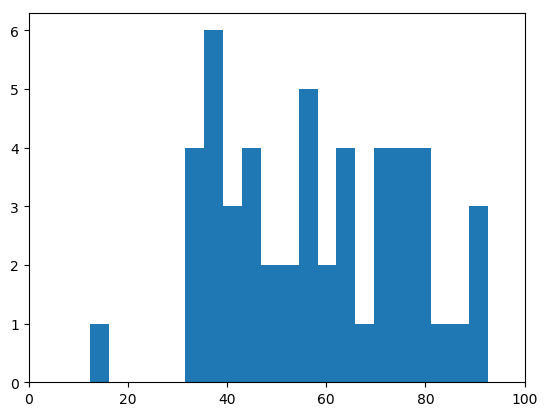

┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = top-level scope at In[191]:2
└ @ Core In[191]:2


(0, 100)

In [191]:
using PyPlot
PyPlot.plt[:hist](pathLengthList./1000, bins=400)
PyPlot.xlim(0,100)

In [192]:
using ProgressMeter

@everywhere function read_vector_cloud(neuronId)
    vectorCloud = SWCs.load(joinpath(DATASET_DIR, "swc.bin/$(neuronId).swc.bin")) |> NBLASTs.VectorCloud
    if isempty(vectorCloud)
        @show neuronId
    end
    vectorCloud[1:3, :]./= Float32(1000)
    vectorCloud
end

vectorCloudList = pmap(read_vector_cloud, neuronIdList)

# make sure that the type is as expected
vectorCloudList = Vector{Matrix{Float32}}(vectorCloudList)
@show length(vectorCloudList)

length(vectorCloudList) = 208


208

# Construct score look up table for Zebrafish data
Although it was claimed useful for clustering zebrafish neurons using Fly score table, it would still be best to construct the lookup table of our own.

In [207]:
using NearestNeighbors

function accumulate_range_count!(ria::RangeIndexingArray{T,N}, 
                                    target::Matrix{T}, query::Matrix{T}, 
                                    adpList::Vector{Float32}, distList::Vector{Float32},
                                    targetTree::KDTree=VectorClouds.to_kd_tree(target)) where {T,N}
    idxs, dists = knn(targetTree, query[1:3, :], 1, false)
    for (i, nodeIndexList) in idxs |> enumerate 
        targetNodeIndex = nodeIndexList[1]
        dist = dists[i][1]
        
        queryVector = query[4:6, i]
        targetVector = target[4:6, targetNodeIndex]
        adp = abs( dot(queryVector, targetVector) )
        
        ria[dist, adp] += one(T)
        
        if rem(i, 100) == 0
            push!(adpList, adp)
            push!(distList, dist)
        end
    end
end

pMatchLookupTable = deepcopy(ria)
fill!(pMatchLookupTable, zero(Float32))


adpMatchList = Vector{Float32}()
distMatchList = Vector{Float32}()

totalNumNeurons = 0
for groupName in Set([:AbdR, :AbdC, :ABDiR, :ABDiC, :TangentialVestibularNeurons])
    local neuronIdList
    neuronIdList = manualClustering[groupName]
    totalNumNeurons += length(neuronIdList)
# @showprogress for (groupName, neuronIdList) in manualClustering
#     Threads.@threads for i in 1:length(neuronIdList)
    for i in 1:length(neuronIdList)
        neuronId1 = neuronIdList[i]
        vectorCloud1 = vectorCloudList[ i ]
        for j in i+1:length(neuronIdList)
            neuronId2 = neuronIdList[j]
            vectorCloud2 = vectorCloudList[ j ]
            accumulate_range_count!(pMatchLookupTable, vectorCloud1, vectorCloud2, adpMatchList, distMatchList)
            accumulate_range_count!(pMatchLookupTable, vectorCloud2, vectorCloud1, adpMatchList, distMatchList)
        end
    end
end

@show maximum(pMatchLookupTable.table)
pMatchLookupTable.table ./= sum(pMatchLookupTable.table)

@show totalNumNeurons
pMatchLookupTable

maximum(pMatchLookupTable.table) = 8129.0f0
totalNumNeurons = 51


RangeIndexingArray{Float32,2}((Float32[0.0, 0.75, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 5.0, 6.0  …  9.0, 10.0, 12.0, 14.0, 16.0, 20.0, 25.0, 30.0, 40.0, 500.0], Float32[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]), Float32[0.00225787 0.00294587 … 0.00543941 0.0130949; 0.00861335 0.00966626 … 0.0171279 0.0308993; … ; 0.0 0.0 … 0.0 6.0818e-5; 0.0 0.0 … 0.0 0.0])

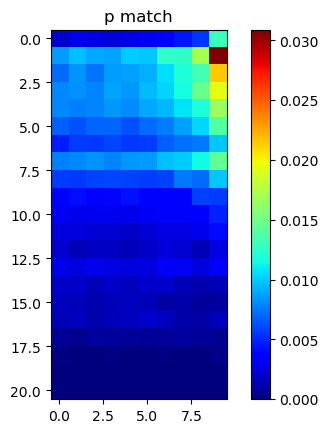

In [208]:
using PyPlot
PyPlot.imshow(pMatchLookupTable.table, interpolation="none", cmap="jet")
PyPlot.colorbar()
PyPlot.title("p match")
PyPlot.savefig("$(DATASET_DIR)/figs/p_match.svg")

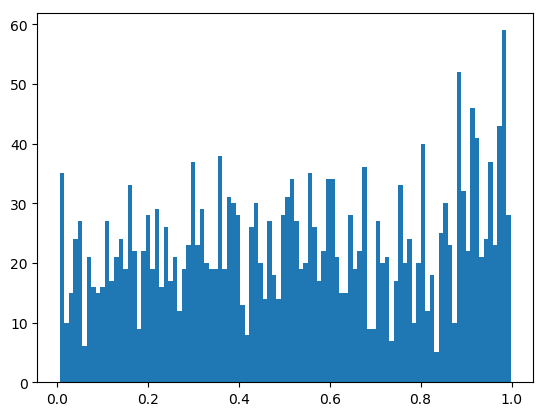

┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = top-level scope at In[209]:1
└ @ Core In[209]:1


([35.0, 10.0, 15.0, 24.0, 27.0, 6.0, 21.0, 16.0, 15.0, 16.0  …  22.0, 46.0, 41.0, 21.0, 24.0, 37.0, 23.0, 43.0, 59.0, 28.0], Float32[0.00633801, 0.0162591, 0.0261802, 0.0361012, 0.0460223, 0.0559434, 0.0658645, 0.0757855, 0.0857066, 0.0956277  …  0.909156, 0.919077, 0.928998, 0.938919, 0.94884, 0.958761, 0.968682, 0.978604, 0.988525, 0.998446], PyCall.PyObject[PyObject <matplotlib.patches.Rectangle object at 0x7f61e70eea20>, PyObject <matplotlib.patches.Rectangle object at 0x7f61e70eecf8>, PyObject <matplotlib.patches.Rectangle object at 0x7f61e27a2320>, PyObject <matplotlib.patches.Rectangle object at 0x7f61e27a2940>, PyObject <matplotlib.patches.Rectangle object at 0x7f61e496edd8>, PyObject <matplotlib.patches.Rectangle object at 0x7f61e496e9e8>, PyObject <matplotlib.patches.Rectangle object at 0x7f61e496ec18>, PyObject <matplotlib.patches.Rectangle object at 0x7f61e496e940>, PyObject <matplotlib.patches.Rectangle object at 0x7f61e496eb70>, PyObject <matplotlib.patches.Rectangle obje

In [209]:
PyPlot.plt[:hist](adpMatchList, bins=100)

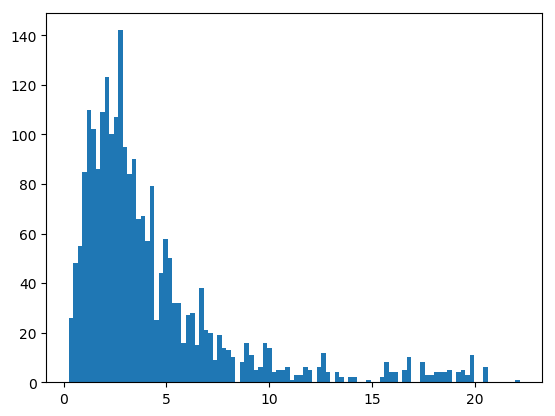

┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = top-level scope at In[210]:1
└ @ Core In[210]:1


([26.0, 48.0, 55.0, 85.0, 110.0, 102.0, 86.0, 109.0, 123.0, 100.0  …  0.0, 0.0, 6.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0], Float32[0.243566, 0.462765, 0.681965, 0.901164, 1.12036, 1.33956, 1.55876, 1.77796, 1.99716, 2.21636  …  20.1907, 20.4099, 20.6291, 20.8483, 21.0675, 21.2867, 21.5059, 21.7251, 21.9443, 22.1635], PyCall.PyObject[PyObject <matplotlib.patches.Rectangle object at 0x7f61e707ed68>, PyObject <matplotlib.patches.Rectangle object at 0x7f61e707eb70>, PyObject <matplotlib.patches.Rectangle object at 0x7f61e16c3d68>, PyObject <matplotlib.patches.Rectangle object at 0x7f61e16c31d0>, PyObject <matplotlib.patches.Rectangle object at 0x7f61e16c3780>, PyObject <matplotlib.patches.Rectangle object at 0x7f61e16c3710>, PyObject <matplotlib.patches.Rectangle object at 0x7f61e16c3470>, PyObject <matplotlib.patches.Rectangle object at 0x7f61e16cd438>, PyObject <matplotlib.patches.Rectangle object at 0x7f61e16cd780>, PyObject <matplotlib.patches.Rectangle object at 0x7f61e16cdac8>  …  PyOb

In [210]:
PyPlot.plt[:hist](distMatchList, bins=100)

In [211]:
# use analysis neurons for random neuron generation
using JSON
mostNeuronIdList = JSON.parsefile("$(DATASET_DIR)/neuron_ids.json")["analysis"]

neuronId2vectorCloud = Dict{Int, Matrix{Float32}}()
@showprogress for neuronId in mostNeuronIdList
#     swc = SWCs.load("$(DATASET_DIR)/swc.bin/$(neuronId).swc.bin")
    neuron = Neurons.load("$(DATASET_DIR)/bin/$(neuronId).bin")
    
    vectorCloud = NBLASTs.VectorCloud(neuron)
    vectorCloud[1:3, :] ./= Float32(1000)
    neuronId2vectorCloud[ neuronId ] = vectorCloud
end

Progress: 100%|█████████████████████████████████████████| Time: 0:01:31


In [212]:
pRandomLookupTable = deepcopy(ria)
fill!(pRandomLookupTable, zero(Float32))

# @showprogress for i in 1:length(mostNeuronIdList)
#     neuronId1 = mostNeuronIdList[i]
#     vectorCloud1 = neuronId2vectorCloud[ neuronId1 ]
#     for j in i+1:length(mostNeuronIdList)
#         neuronId2 = mostNeuronIdList[j]
#         vectorCloud2 = neuronId2vectorCloud[ neuronId2 ]
#         accumulate_range_count!(pRandomLookupTable, vectorCloud1, vectorCloud2)
#         accumulate_range_count!(pRandomLookupTable, vectorCloud2, vectorCloud1)
#     end
# end

# empty the adp and dist list
adpRandomList = Vector{Float32}()
distRandomList = Vector{Float32}()

function compute_rand_pair(mostNeuronIdSet, neuronId2vectorCloud)
    neuronId1, neuronId2 = rand(mostNeuronIdSet, 2)
    if neuronId1 == neuronId2 
        return
    end
    vectorCloud1 = neuronId2vectorCloud[ neuronId1 ]
    vectorCloud2 = neuronId2vectorCloud[ neuronId2 ]
    accumulate_range_count!(pRandomLookupTable, vectorCloud1, vectorCloud2, adpRandomList, distRandomList)
end

# n = zero(Int)
mostNeuronIdSet = Set{Int}(mostNeuronIdList)
@showprogress for i in 1:3e5
   compute_rand_pair(mostNeuronIdSet, neuronId2vectorCloud) 
end

@show maximum(pRandomLookupTable.table)
pRandomLookupTable.table ./= sum(pRandomLookupTable.table)

Progress: 100%|█████████████████████████████████████████| Time: 0:07:24


maximum(pRandomLookupTable.table) = 8.774032f6


21×10 Array{Float32,2}:
 9.91406e-5   9.68699e-5   9.81726e-5   …  0.000183785  0.000371202
 0.000321748  0.000324826  0.000322693     0.000536122  0.000929386
 0.000321318  0.000323374  0.000321659     0.000507983  0.000816071
 0.000395367  0.000396736  0.00039324      0.0006052    0.000943417
 0.00045973   0.000455661  0.000462336     0.000677343  0.00102593 
 0.00051314   0.000514102  0.000509823  …  0.000734792  0.00110338 
 0.000560771  0.000561261  0.000555339     0.000785919  0.00115856 
 0.00124555   0.00124856   0.00122958      0.00169859   0.00245412 
 0.0013813    0.00137144   0.00135425      0.00182668   0.00260622 
 0.00148329   0.00146891   0.00145081      0.00191816   0.00272883 
 0.00155408   0.00154001   0.00152115   …  0.00198615   0.00279811 
 0.00162152   0.00160234   0.00157492      0.00203671   0.00281619 
 0.00166834   0.00164712   0.00161829      0.002064     0.00281616 
 0.00344143   0.00337817   0.00331032      0.00413435   0.00558976 
 0.0035075    0.00346624

In [213]:
rand(mostNeuronIdSet, 2)

2-element Array{Int64,1}:
 77444
 77030

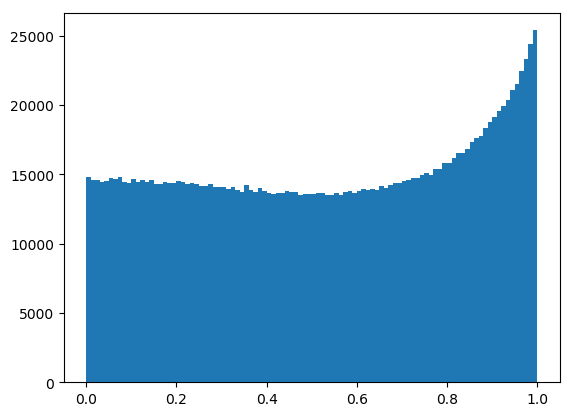

┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = top-level scope at In[214]:2
└ @ Core In[214]:2


([14802.0, 14577.0, 14583.0, 14445.0, 14533.0, 14768.0, 14638.0, 14780.0, 14448.0, 14386.0  …  19162.0, 19606.0, 19956.0, 20367.0, 21108.0, 21555.0, 22473.0, 23318.0, 24408.0, 25399.0], Float32[3.27826e-7, 0.0100003, 0.0200003, 0.0300003, 0.0400003, 0.0500003, 0.0600003, 0.0700003, 0.0800003, 0.0900003  …  0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.0], PyCall.PyObject[PyObject <matplotlib.patches.Rectangle object at 0x7f61e4bab128>, PyObject <matplotlib.patches.Rectangle object at 0x7f61e4bb4ef0>, PyObject <matplotlib.patches.Rectangle object at 0x7f61e4bab710>, PyObject <matplotlib.patches.Rectangle object at 0x7f61e4baba58>, PyObject <matplotlib.patches.Rectangle object at 0x7f61e4babda0>, PyObject <matplotlib.patches.Rectangle object at 0x7f61e4babeb8>, PyObject <matplotlib.patches.Rectangle object at 0x7f61e4b46470>, PyObject <matplotlib.patches.Rectangle object at 0x7f61e4b467b8>, PyObject <matplotlib.patches.Rectangle object at 0x7f61e4b46b00>, PyObject <matplotlib.p

In [214]:
using ProgressMeter
PyPlot.plt[:hist](adpRandomList, bins=100)

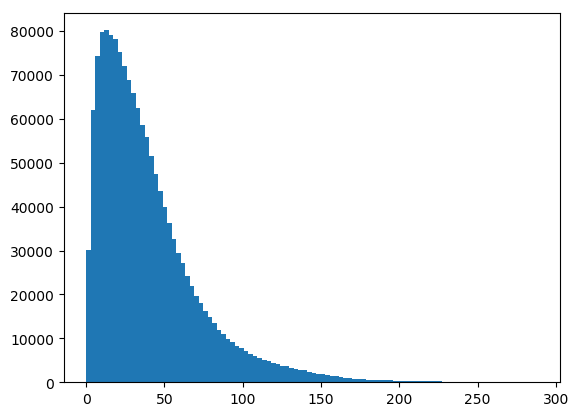

┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = top-level scope at In[215]:1
└ @ Core In[215]:1


([30070.0, 61910.0, 74363.0, 79716.0, 80178.0, 79167.0, 78173.0, 75256.0, 72066.0, 68835.0  …  53.0, 30.0, 38.0, 22.0, 7.0, 8.0, 2.0, 1.0, 0.0, 1.0], Float32[0.0559571, 2.93536, 5.81477, 8.69418, 11.5736, 14.453, 17.3324, 20.2118, 23.0912, 25.9706  …  262.082, 264.961, 267.841, 270.72, 273.6, 276.479, 279.358, 282.238, 285.117, 287.997], PyCall.PyObject[PyObject <matplotlib.patches.Rectangle object at 0x7f61e4a785f8>, PyObject <matplotlib.patches.Rectangle object at 0x7f61dcfa0978>, PyObject <matplotlib.patches.Rectangle object at 0x7f61e4a78be0>, PyObject <matplotlib.patches.Rectangle object at 0x7f61e4a78f28>, PyObject <matplotlib.patches.Rectangle object at 0x7f61e4a78f60>, PyObject <matplotlib.patches.Rectangle object at 0x7f61e4a005f8>, PyObject <matplotlib.patches.Rectangle object at 0x7f61e4a00940>, PyObject <matplotlib.patches.Rectangle object at 0x7f61e4a00c88>, PyObject <matplotlib.patches.Rectangle object at 0x7f61e4a00fd0>, PyObject <matplotlib.patches.Rectangle object at 0

In [215]:
PyPlot.plt[:hist](distRandomList; bins=100)

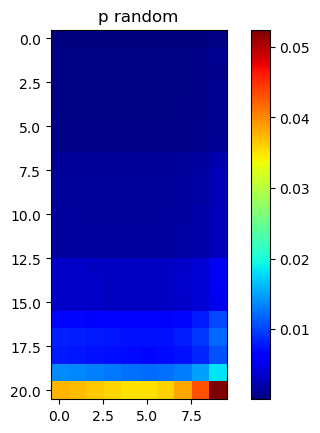

In [216]:
PyPlot.imshow(pRandomLookupTable.table, interpolation="none", cmap="jet")
PyPlot.colorbar()
PyPlot.title("p random")
PyPlot.savefig("$(DATASET_DIR)/figs/p_random.svg")

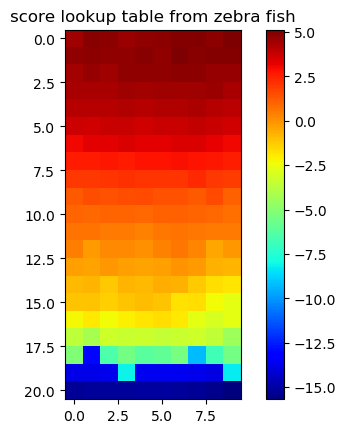

In [217]:
scoreTable = log2.((pMatchLookupTable.table .+ 1e-6) ./ (pRandomLookupTable.table.+1e-6))

zfishRangeIndexingArray = RangeIndexingArray(ria.septaListTuple, scoreTable)

PyPlot.imshow(scoreTable, interpolation="none", cmap="jet")
PyPlot.colorbar()
PyPlot.title("score lookup table from zebra fish")
PyPlot.savefig("$(DATASET_DIR)/figs/zfish_score_table.svg")

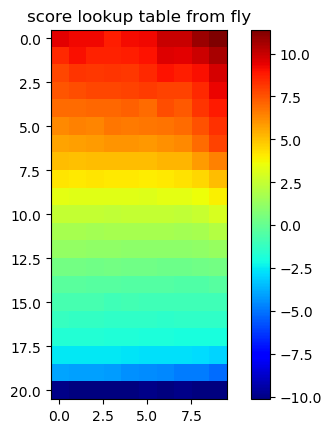

In [218]:
PyPlot.imshow(ria.table, interpolation="none", cmap="jet")
PyPlot.colorbar()
PyPlot.title("score lookup table from fly")
PyPlot.savefig("$(DATASET_DIR)/figs/fly_score_table.svg")

In [219]:
# save zfish score table as csv file
    
df = DataFrame(zfishRangeIndexingArray)

using Pkg
CSV.write(joinpath(Pkg.devdir(), "RealNeuralNetworks/asset/zfish_score_table.csv"), df)

"/usr/opt/julia-1.0.4/local/share/julia/dev/RealNeuralNetworks/asset/zfish_score_table_latest.csv"

In [220]:
df

,Column1,"(0.0,0.1]","(0.1,0.2]","(0.2,0.3]","(0.3,0.4]","(0.4,0.5]","(0.5,0.6]"
,Symbol,Float64,Float64,Float64,Float64,Float64,Float64
1,"(0.0,0.75]",4.4955,4.91217,4.81667,4.59524,4.75981,4.85873
2,"(0.75,1.5]",4.73826,4.89093,4.79512,4.75954,4.90156,4.80875
3,"(1.5,2.0]",4.48074,4.69492,4.5338,4.73145,4.73422,4.74494
4,"(2.0,2.5]",4.33209,4.37308,4.33365,4.49428,4.41996,4.53751
5,"(2.5,3.0]",4.12868,4.10286,4.08262,4.20563,4.13552,4.23549
6,"(3.0,3.5]",3.72071,3.6123,3.76442,3.76746,3.61342,3.77769
7,"(3.5,4.0]",3.09781,3.34425,3.32552,3.44283,3.32357,3.33891
8,"(4.0,5.0]",2.63936,2.6838,2.77587,2.68848,2.79552,2.80647
9,"(5.0,6.0]",2.04457,2.03846,2.11385,2.15561,2.12114,2.07543


UndefVarError: OffsetArray not defined
Stacktrace:
 [1] #collect_args#33(::Bool, ::Function, ::JuliaInterpreter.Frame, ::Expr) at /home/jingpeng/.julia/packages/JuliaInterpreter/Or807/src/interpret.jl:64
 [2] collect_args at /home/jingpeng/.julia/packages/JuliaInterpreter/Or807/src/interpret.jl:139 [inlined]
 [3] lookup_callexpr at /home/jingpeng/.julia/packages/Revise/agmgx/src/lowered.jl:13 [inlined]
 [4] #methods_by_execution!#14(::Bool, ::Bool, ::Function, ::Any, ::Revise.CodeTrackingMethodInfo, ::Dict{Module,Array{Expr,1}}, ::JuliaInterpreter.Frame) at /home/jingpeng/.julia/packages/Revise/agmgx/src/lowered.jl:187
 [5] #methods_by_execution! at ./none:0 [inlined]
 [6] #methods_by_execution!#9(::Base.Iterators.Pairs{Symbol,Bool,Tuple{Symbol},NamedTuple{(:define,),Tuple{Bool}}}, ::Function, ::Any, ::Revise.CodeTrackingMethodInfo, ::Dict{Module,Array{Expr,1}}, ::Module, ::Expr) at /home/jingpeng/.julia/packages/Revise/agmgx/src/lowered.jl:49
 [7] #methods_by_execution! at ./none:0 [i

        OffsetArray{T, N, Array{T, N}}(Array{T, N}(init, map(indexlength, inds)), map(indexoffset, inds))
    end
in module Main.OffsetArrays
Revise.LogRecord(Warn, omitting call expression (Core.apply_type)(Main.OffsetArrays.OffsetArray, T) in ("none", 0), lowered, Revise_c21d3a4d, "/home/jingpeng/.julia/packages/Revise/agmgx/src/lowered.jl", 188)UndefVarError: ArrayInitializer not defined
Stacktrace:
 [1] #collect_args#33(::Bool, ::Function, ::JuliaInterpreter.Frame, ::Expr) at /home/jingpeng/.julia/packages/JuliaInterpreter/Or807/src/interpret.jl:64
 [2] collect_args at /home/jingpeng/.julia/packages/JuliaInterpreter/Or807/src/interpret.jl:139 [inlined]
 [3] lookup_callexpr at /home/jingpeng/.julia/packages/Revise/agmgx/src/lowered.jl:13 [inlined]
 [4] #methods_by_execution!#14(::Bool, ::Bool, ::Function, ::Any, ::Revise.CodeTrackingMethodInfo, ::Dict{Module,Array{Expr,1}}, ::JuliaInterpreter.Frame) at /home/jingpeng/.julia/packages/Revise/agmgx/src/lowered.jl:187
 [5] #methods_by_e

 [2] collect_args at /home/jingpeng/.julia/packages/JuliaInterpreter/Or807/src/interpret.jl:139 [inlined]
 [3] lookup_callexpr at /home/jingpeng/.julia/packages/Revise/agmgx/src/lowered.jl:13 [inlined]
 [4] #methods_by_execution!#14(::Bool, ::Bool, ::Function, ::Any, ::Revise.CodeTrackingMethodInfo, ::Dict{Module,Array{Expr,1}}, ::JuliaInterpreter.Frame) at /home/jingpeng/.julia/packages/Revise/agmgx/src/lowered.jl:187
 [5] #methods_by_execution! at ./none:0 [inlined]
 [6] #methods_by_execution!#9(::Base.Iterators.Pairs{Symbol,Bool,Tuple{Symbol},NamedTuple{(:define,),Tuple{Bool}}}, ::Function, ::Any, ::Revise.CodeTrackingMethodInfo, ::Dict{Module,Array{Expr,1}}, ::Module, ::Expr) at /home/jingpeng/.julia/packages/Revise/agmgx/src/lowered.jl:49
 [7] #methods_by_execution! at ./none:0 [inlined]
 [8] #eval_with_signatures#59 at /home/jingpeng/.julia/packages/Revise/agmgx/src/Revise.jl:344 [inlined]
 [9] #eval_with_signatures at ./none:0 [inlined]
 [10] #instantiate_sigs!#60(::Bool, ::Base

 [13] (::getfield(Revise, Symbol("##26#27")){String})() at /home/jingpeng/.julia/packages/Revise/agmgx/src/pkgs.jl:370
 [14] with_logstate(::getfield(Revise, Symbol("##26#27")){String}, ::Base.CoreLogging.LogState) at ./logging.jl:395
 [15] with_logger at ./logging.jl:491 [inlined]
 [16] watch_manifest(::String) at /home/jingpeng/.julia/packages/Revise/agmgx/src/pkgs.jl:349
 [17] (::Revise.Rescheduler{typeof(Revise.watch_manifest),Tuple{String}})() at /home/jingpeng/.julia/packages/Revise/agmgx/src/types.jl:235
while evaluating
#= /usr/opt/julia-1.0.4/local/share/julia/packages/OffsetArrays/ruvC7/src/OffsetArrays.jl:45 =# @deprecate OffsetArray{T}(inds::Vararg{AbstractUnitRange, N}) where {T, N} OffsetArray{T}(undef, inds)
in module Main.OffsetArrays
TypeError: in Type{...} expression, expected UnionAll, got typeof(Main.OffsetArrays.OffsetVector)
Stacktrace:
 [1] top-level scope at none:0
 [2] eval at ./boot.jl:319 [inlined]
 [3] prepare_thunk(::Module, ::Expr, ::Bool) at /home/jingpen

 [14] #eval_with_signatures at ./none:0 [inlined]
 [15] #instantiate_sigs!#60(::Bool, ::Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}, ::Function, ::OrderedCollections.OrderedDict{Module,OrderedCollections.OrderedDict{Revise.RelocatableExpr,Union{Nothing, Array{Any,1}}}}) at /home/jingpeng/.julia/packages/Revise/agmgx/src/Revise.jl:352
 [16] instantiate_sigs! at /home/jingpeng/.julia/packages/Revise/agmgx/src/Revise.jl:349 [inlined]
 [17] maybe_parse_from_cache!(::Revise.PkgData, ::String) at /home/jingpeng/.julia/packages/Revise/agmgx/src/pkgs.jl:224
 [18] (::getfield(Revise, Symbol("##26#27")){String})() at /home/jingpeng/.julia/packages/Revise/agmgx/src/pkgs.jl:370
 [19] with_logstate(::getfield(Revise, Symbol("##26#27")){String}, ::Base.CoreLogging.LogState) at ./logging.jl:395
 [20] with_logger at ./logging.jl:491 [inlined]
 [21] watch_manifest(::String) at /home/jingpeng/.julia/packages/Revise/agmgx/src/pkgs.jl:349
 [22] (::Revise.Rescheduler{typeof(Revise.

Revise.LogRecord(Warn, omitting call expression (Core.apply_type)(Main.OffsetArrays.OffsetArray, T, 0) in ("none", 0), lowered, Revise_c21d3a4d, "/home/jingpeng/.julia/packages/Revise/agmgx/src/lowered.jl", 188)UndefVarError: IdentityUnitRange not defined
Stacktrace:
 [1] #collect_args#33(::Bool, ::Function, ::JuliaInterpreter.Frame, ::Expr) at /home/jingpeng/.julia/packages/JuliaInterpreter/Or807/src/interpret.jl:64
 [2] collect_args at /home/jingpeng/.julia/packages/JuliaInterpreter/Or807/src/interpret.jl:139 [inlined]
 [3] lookup_callexpr at /home/jingpeng/.julia/packages/Revise/agmgx/src/lowered.jl:13 [inlined]
 [4] #methods_by_execution!#14(::Bool, ::Bool, ::Function, ::Any, ::Revise.CodeTrackingMethodInfo, ::Dict{Module,Array{Expr,1}}, ::JuliaInterpreter.Frame) at /home/jingpeng/.julia/packages/Revise/agmgx/src/lowered.jl:187
 [5] #methods_by_execution! at ./none:0 [inlined]
 [6] #methods_by_execution!#9(::Base.Iterators.Pairs{Symbol,Bool,Tuple{Symbol},NamedTuple{(:define,),Tuple

 [7] #methods_by_execution! at ./none:0 [inlined]
 [8] #eval_with_signatures#59 at /home/jingpeng/.julia/packages/Revise/agmgx/src/Revise.jl:344 [inlined]
 [9] #eval_with_signatures at ./none:0 [inlined]
 [10] #instantiate_sigs!#60(::Bool, ::Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}, ::Function, ::OrderedCollections.OrderedDict{Module,OrderedCollections.OrderedDict{Revise.RelocatableExpr,Union{Nothing, Array{Any,1}}}}) at /home/jingpeng/.julia/packages/Revise/agmgx/src/Revise.jl:352
 [11] instantiate_sigs! at /home/jingpeng/.julia/packages/Revise/agmgx/src/Revise.jl:349 [inlined]
 [12] maybe_parse_from_cache!(::Revise.PkgData, ::String) at /home/jingpeng/.julia/packages/Revise/agmgx/src/pkgs.jl:224
 [13] (::getfield(Revise, Symbol("##26#27")){String})() at /home/jingpeng/.julia/packages/Revise/agmgx/src/pkgs.jl:370
 [14] with_logstate(::getfield(Revise, Symbol("##26#27")){String}, ::Base.CoreLogging.LogState) at ./logging.jl:395
 [15] with_logger at ./logging

UndefVarError: OffsetRange not defined
Stacktrace:
 [1] #collect_args#33(::Bool, ::Function, ::JuliaInterpreter.Frame, ::Expr) at /home/jingpeng/.julia/packages/JuliaInterpreter/Or807/src/interpret.jl:64
 [2] collect_args at /home/jingpeng/.julia/packages/JuliaInterpreter/Or807/src/interpret.jl:139 [inlined]
 [3] lookup_callexpr at /home/jingpeng/.julia/packages/Revise/agmgx/src/lowered.jl:13 [inlined]
 [4] #methods_by_execution!#14(::Bool, ::Bool, ::Function, ::Any, ::Revise.CodeTrackingMethodInfo, ::Dict{Module,Array{Expr,1}}, ::JuliaInterpreter.Frame) at /home/jingpeng/.julia/packages/Revise/agmgx/src/lowered.jl:187
 [5] #methods_by_execution! at ./none:0 [inlined]
 [6] #methods_by_execution!#9(::Base.Iterators.Pairs{Symbol,Bool,Tuple{Symbol},NamedTuple{(:define,),Tuple{Bool}}}, ::Function, ::Any, ::Revise.CodeTrackingMethodInfo, ::Dict{Module,Array{Expr,1}}, ::Module, ::Expr) at /home/jingpeng/.julia/packages/Revise/agmgx/src/lowered.jl:49
 [7] #methods_by_execution! at ./none:0 [i

 [10] #instantiate_sigs!#60(::Bool, ::Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}, ::Function, ::OrderedCollections.OrderedDict{Module,OrderedCollections.OrderedDict{Revise.RelocatableExpr,Union{Nothing, Array{Any,1}}}}) at /home/jingpeng/.julia/packages/Revise/agmgx/src/Revise.jl:352
 [11] instantiate_sigs! at /home/jingpeng/.julia/packages/Revise/agmgx/src/Revise.jl:349 [inlined]
 [12] maybe_parse_from_cache!(::Revise.PkgData, ::String) at /home/jingpeng/.julia/packages/Revise/agmgx/src/pkgs.jl:224
 [13] (::getfield(Revise, Symbol("##26#27")){String})() at /home/jingpeng/.julia/packages/Revise/agmgx/src/pkgs.jl:370
 [14] with_logstate(::getfield(Revise, Symbol("##26#27")){String}, ::Base.CoreLogging.LogState) at ./logging.jl:395
 [15] with_logger at ./logging.jl:491 [inlined]
 [16] watch_manifest(::String) at /home/jingpeng/.julia/packages/Revise/agmgx/src/pkgs.jl:349
 [17] (::Revise.Rescheduler{typeof(Revise.watch_manifest),Tuple{String}})() at /home/jingpen

 [14] with_logstate(::getfield(Revise, Symbol("##26#27")){String}, ::Base.CoreLogging.LogState) at ./logging.jl:395
 [15] with_logger at ./logging.jl:491 [inlined]
 [16] watch_manifest(::String) at /home/jingpeng/.julia/packages/Revise/agmgx/src/pkgs.jl:349
 [17] (::Revise.Rescheduler{typeof(Revise.watch_manifest),Tuple{String}})() at /home/jingpeng/.julia/packages/Revise/agmgx/src/types.jl:235
while evaluating
#= /usr/opt/julia-1.0.4/local/share/julia/packages/OffsetArrays/ruvC7/src/OffsetArrays.jl:179 =# @inline #= /usr/opt/julia-1.0.4/local/share/julia/packages/OffsetArrays/ruvC7/src/OffsetArrays.jl:179 =# @propagate_inbounds((Base.getindex(r::StepRangeLen{T}, s::IIUR) where T) = begin
                #= /usr/opt/julia-1.0.4/local/share/julia/packages/OffsetArrays/ruvC7/src/OffsetArrays.jl:179 =#
                OffsetArray(r[s.indices], s)
            end)
in module Main.OffsetArrays
UndefVarError: IIUR not defined
Stacktrace:
 [1] #collect_args#33(::Bool, ::Function, ::JuliaInterp

Base.show(io::IO, ::#= /usr/opt/julia-1.0.4/local/share/julia/packages/OffsetArrays/ruvC7/src/OffsetArrays.jl:190 =# @MIME_str("text/plain"), r::OffsetRange) = begin
        #= /usr/opt/julia-1.0.4/local/share/julia/packages/OffsetArrays/ruvC7/src/OffsetArrays.jl:190 =#
        show(io, r)
    end
in module Main.OffsetArrays
UndefVarError: IdentityUnitRange not defined
Stacktrace:
 [1] macro expansion at /home/jingpeng/.julia/packages/JuliaInterpreter/Or807/src/interpret.jl:64 [inlined]
 [2] getargs(::Array{Any,1}, ::JuliaInterpreter.Frame) at /home/jingpeng/.julia/packages/JuliaInterpreter/Or807/src/builtins.jl:8
 [3] maybe_evaluate_builtin(::JuliaInterpreter.Frame, ::Expr, ::Bool) at /home/jingpeng/.julia/packages/JuliaInterpreter/Or807/src/builtins.jl:136
 [4] #evaluate_call_recurse!#37(::Bool, ::Function, ::Any, ::JuliaInterpreter.Frame, ::Expr) at /home/jingpeng/.julia/packages/JuliaInterpreter/Or807/src/interpret.jl:209
 [5] evaluate_call_recurse! at /home/jingpeng/.julia/package